# Analysis & Plot the Asphalt Binder Test Results. 

This notebook include the codes to analyze and plot the results of the asphalt binder rheology and failure tests, including the high-temperature performance grade (HTPG), low-temperature performance grade (LTPG), double-edge notched test (DENT), LTPG loss (extended BBR), Glover-Rowe (G-R) parameter.

Author: Farhad Abdollahi (farhad.abdollahi.ctr@dot.gov)

Date: 04/23/2025

Update: 05/12/2025
_____

In [1]:
# Importing the required libraries.
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from sklearn.metrics import r2_score
from scipy.stats import ttest_ind, t

In [2]:
# User defined variables. 
MainDataFile = './Data.xlsx'

_______

## Plot 04: Asphalt binder performance grade (rheological properties). 

Calculate and analyze the high- and low-temperature performance grade (HTPG) of asphalt binders recovered from the different asphalt mixtures, including (i) high-RAP (40% RAP by weight of total mixture) asphalt mixtures modified with bio-based RA, denoted as **40RAP-B**, (ii) high-RAP (40% RAP by weight of total mixture) asphalt mixture modified with petroleum-based RA, denoted as **40RAP-P**, (i) control (20% RAP by weight of total mixture) asphalt mixture, denoted as **20RAP**. 

In [3]:
def checkArr(Arr):
    if np.array(Arr).std() / np.array(Arr).mean() * 100 < 2:
        return np.array(Arr)
    Arr = np.array(Arr)
    Combs= list(itertools.combinations(np.arange(len(Arr)), 2))
    COVs = np.zeros(len(Combs))
    for i, comb in enumerate(Combs):
        comb = np.array(comb)
        COVs[i] = Arr[comb].std() / Arr[comb].mean() * 100
    return Arr[np.array(Combs[np.argmin(COVs)])]

Read the HTPG results from the `Data.xlsx` file. 

In [4]:
# Create a new dictionary to save the rheology results. 
RheoRes = {
    'HTPG_mean': [0, 0, 0],    'HTPG_std': [0, 0, 0],    'HTPG_data': [[], [], []],
    'LTPG_mean': [0, 0, 0],    'LTPG_std': [0, 0, 0],    'LTPG_data': [[], [], []],
    'DeltaTc_mean': [0, 0, 0], 'DeltaTc_std': [0, 0, 0], 'DeltaTc_data': [[], [], []]}
# Read the HTPG data. 
HTPGdata = pd.read_excel(MainDataFile, sheet_name='HTPG', names=['Binder', 'Rep1', 'Rep2', 'Rep3'], skiprows=1)
RheoRes['HTPG_data'] = [HTPGdata.loc[0, [f'Rep{i}' for i in range(1, 4)]].to_numpy().astype(float).tolist(), 
                        HTPGdata.loc[1, [f'Rep{i}' for i in range(1, 4)]].to_numpy().astype(float).tolist(), 
                        HTPGdata.loc[2, [f'Rep{i}' for i in range(1, 4)]].to_numpy().astype(float).tolist()]
RheoRes['HTPG_mean'] = [HTPGdata.loc[0, [f'Rep{i}' for i in range(1, 4)]].to_numpy().astype(float).mean(), 
                        HTPGdata.loc[1, [f'Rep{i}' for i in range(1, 4)]].to_numpy().astype(float).mean(), 
                        HTPGdata.loc[2, [f'Rep{i}' for i in range(1, 4)]].to_numpy().astype(float).mean()]
RheoRes['HTPG_std'] =  [HTPGdata.loc[0, [f'Rep{i}' for i in range(1, 4)]].to_numpy().astype(float).std(), 
                        HTPGdata.loc[1, [f'Rep{i}' for i in range(1, 4)]].to_numpy().astype(float).std(), 
                        HTPGdata.loc[2, [f'Rep{i}' for i in range(1, 4)]].to_numpy().astype(float).std()]

Read the LTPG raw data (S-value and m-value) and calculate the LTPG based on S-value of 300 MPa and m-value of 0.300 using all different combinations of the BBR tests at different tested temperatures to get the statistical distribution of the LTPG and ΔTc. 

In [5]:
# Calculating the LTPG values and Delta Tc. 
LTPGdata = pd.read_excel(MainDataFile, sheet_name='LTPG', usecols='E,F,G,L,M,N,S,T,U', skiprows=8, 
                         names=['L7R1', 'L7R2', 'L7R3', 'L8R1', 'L8R2', 'L8R3', 'L9R1', 'L9R2', 'L9R3'])    # Read the data.
TempPairs = [[-12, -18], [-12, -18], [-12, -18]]        # Temperatures to calculate the LTPG. 
for ii, ln in enumerate([7, 8, 9]):            # Iterate over different lanes. 
    SMat = np.array([
        [LTPGdata.loc[2, f'L{ln}R1'], LTPGdata.loc[6, f'L{ln}R1']], 
        [LTPGdata.loc[2, f'L{ln}R2'], LTPGdata.loc[6, f'L{ln}R2']], 
        [LTPGdata.loc[2, f'L{ln}R3'], LTPGdata.loc[6, f'L{ln}R3']]])
    mMat = np.array([
        [LTPGdata.loc[3, f'L{ln}R1'], LTPGdata.loc[7, f'L{ln}R1']], 
        [LTPGdata.loc[3, f'L{ln}R2'], LTPGdata.loc[7, f'L{ln}R2']], 
        [LTPGdata.loc[3, f'L{ln}R3'], LTPGdata.loc[7, f'L{ln}R3']]])
    Index1 = np.where(~np.isnan(SMat).any(axis=1))[0]
    Index2 = np.where(~np.isnan(mMat).any(axis=1))[0]
    if len(Index1) == 0 or len(Index2) == 0:
        raise Exception(f"Not enough data!!!! for lane {ln}")
    if len(Index1) > 1:
        Index1 = Index1[np.argmin(np.abs(300 - np.mean(SMat[Index1, :], axis=1)))]
    else:
        Index1 = Index1[0]
    if len(Index2) > 1:
        Index2 = Index2[np.argmin(np.abs(0.300 - np.mean(mMat[Index2, :], axis=1)))]
    else:
        Index2 = Index2[0]
    # ------------------------------------------------------------------------------------------------------------------
    # Calculate LTPG for 1 PAV and based on S-value. 
    t1, t2 = TempPairs[Index1]
    Svals_t1 = checkArr([LTPGdata.loc[2, f'L{ln}R{i}'] for i in [1, 2, 3]])
    Svals_t2 = checkArr([LTPGdata.loc[6, f'L{ln}R{i}'] for i in [1, 2, 3]])
    Combinations = list(itertools.product(range(len(Svals_t1)), range(len(Svals_t2))))
    LTPG1S = np.zeros(len(Combinations))
    for i, comb in enumerate(Combinations):
        Slope     = (Svals_t2[comb[1]] - Svals_t1[comb[0]]) / (t2 - t1)
        Intercept = Svals_t1[comb[0]] - Slope * t1
        LTPG1S[i] = (300 - Intercept) / Slope
    # ------------------------------------------------------------------------------------------------------------------
    # Calculating the LTPG for 1 PAV based on m-value. 
    t1, t2 = TempPairs[Index2]
    mvals_t1 = checkArr([LTPGdata.loc[3, f'L{ln}R{i}'] for i in [1, 2, 3]])
    mvals_t2 = checkArr([LTPGdata.loc[7, f'L{ln}R{i}'] for i in [1, 2, 3]])
    Combinations = list(itertools.product(range(len(mvals_t1)), range(len(mvals_t2))))
    LTPG1m = np.zeros(len(Combinations))
    for i, comb in enumerate(Combinations):
        Slope     = (mvals_t2[comb[1]] - mvals_t1[comb[0]]) / (t2 - t1)
        Intercept = mvals_t1[comb[0]] - Slope * t1
        LTPG1m[i] = (0.3 - Intercept) / Slope
    # ------------------------------------------------------------------------------------------------------------------
    # Calculating the Delta Tc for 1PAV.
    RheoRes['DeltaTc_mean'][ii] = LTPG1S.mean() - LTPG1m.mean()
    RheoRes['DeltaTc_std'][ii]  = np.sqrt(LTPG1S.std() ** 2 + LTPG1m.std() ** 2)
    # ------------------------------------------------------------------------------------------------------------------
    # Store the results. 
    if LTPG1m.mean() < LTPG1S.mean():
        RheoRes['LTPG_mean'][ii] = LTPG1S.mean() - 10
        RheoRes['LTPG_std'][ii]  = LTPG1S.std()
    else:
        RheoRes['LTPG_mean'][ii] = LTPG1m.mean() - 10
        RheoRes['LTPG_std'][ii]  = LTPG1m.std()

Plot the basic rheological proerties of the recovered binders (HTPG, LTPG, and ΔTc).

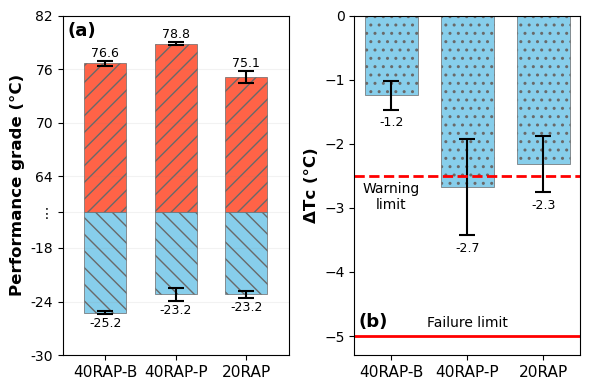

In [6]:
# Plot the results. 
fig, ax = plt.subplots(1, 2, figsize=(6, 4))
ax[0].bar([1, 2, 3], height=np.array(RheoRes['HTPG_mean']) - 60, yerr=RheoRes['HTPG_std'], width=0.6, 
          edgecolor='dimgray', lw=0.5, color='tomato', hatch='//', 
          error_kw={'capsize': 6, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
ax[0].bar([1, 2, 3], height=np.array(RheoRes['LTPG_mean']) + 14, yerr=RheoRes['LTPG_std'], width=0.6, 
          edgecolor='dimgray', lw=0.5, color='skyblue', hatch='\\\\', 
          error_kw={'capsize': 6, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
ax[0].set_yticks([-16, -10, -4, 0, 4, 10, 16, 22])
ax[0].set_yticklabels(['-30', '-24', '-18', '⋮', '64', '70', '76', '82'])
ax[0].set_xticks([1, 2, 3])
ax[0].set_xticklabels(['40RAP-B', '40RAP-P', '20RAP'], fontsize=11, color='k', rotation=0)
ax[0].set_ylabel('Performance grade (°C)', fontsize=12, fontweight='bold', color='k')
for i in range(3):
    ax[0].text(i + 1, RheoRes['HTPG_mean'][i] + RheoRes['HTPG_std'][i] + 0.1 - 60, f'{RheoRes["HTPG_mean"][i]:.1f}', 
            ha='center', va='bottom', fontsize=9)
    ax[0].text(i + 1, RheoRes['LTPG_mean'][i] - RheoRes['LTPG_std'][i] - 0.3 + 14, f'{RheoRes["LTPG_mean"][i]:.1f}', 
            ha='center', va='top', fontsize=9)
ax[0].set_xlim([0.4, 3.6])
ax[0].grid(axis='y', color='gray', alpha=0.1)
ax[0].text(0.02, 0.98, '(a)', transform=ax[0].transAxes, fontsize=13, 
             fontweight='bold', color='k', va='top', ha='left')
# ----------------------------------------------------------------------------------------------------------------------
ax[1].bar([1, 2, 3], height=RheoRes['DeltaTc_mean'], yerr=RheoRes['DeltaTc_std'], width=0.7, 
            edgecolor='dimgray', lw=0.5, color='skyblue', hatch='..', 
            error_kw={'capsize': 6, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
for i in range(3):
    ax[1].text(i + 1, RheoRes['DeltaTc_mean'][i] - RheoRes['DeltaTc_std'][i] - 0.1, 
                 f'{RheoRes["DeltaTc_mean"][i]:.1f}', 
                 ha='center', va='top', fontsize=9)
ax[1].axhline(y=-5.0, ls='-', lw=2, color='r')
ax[1].axhline(y=-2.5, ls='--', lw=2, color='r')
ax[1].text(2.0, -4.9, 'Failure limit', va='bottom', ha='center', fontsize=10)
ax[1].text(1.0, -2.6, 'Warning\nlimit', va='top', ha='center', fontsize=10)
ax[1].set_ylim([-5.3, 0])
ax[1].set_ylabel('ΔΤc (°C)', fontsize=12, fontweight='bold', color='k')
ax[1].text(0.02, 0.07, '(b)', transform=ax[1].transAxes, fontsize=13, 
             fontweight='bold', color='k', va='bottom', ha='left')
ax[1].set_xticks([1, 2, 3])
ax[1].set_xticklabels(['40RAP-B', '40RAP-P', '20RAP'], fontsize=11, color='k', rotation=0)
fig.tight_layout()
# fig.savefig('../_Figures/Figure04_Rheological_Properties.png', format='png', dpi=1000)
# fig.savefig('../_Figures/Figure04_Rheological_Properties.pdf', format='pdf')
# fig.savefig('../_Figures/Figure04_Rheological_Properties.svg', format='svg')

_______

## Plot 05: G-R parameter (rheological property). 

Read the |G*| and phase angle data for each recovered asphalt binder from the `Data.xlsx` file to calculate the G-R parameters using the following equation:

$G-R=\frac{|G^*| \left( \cos \delta \right)^2}{\sin \delta}$

It is noted that the |G*| and δ was calculated by Dynamoc Shear Rheometer (DSR) device at the testing temperature of 44.7°C and loading frequency of 10 rad/s. 

In [7]:
GRdata = pd.read_excel(MainDataFile, sheet_name='Glover-Rowe (G-R)', usecols='A:E', skiprows=0,
                       names=['ID', 'Age', 'Gstar', 'Phase', 'G-R'])
GRdata

,ID,Age,Gstar,Phase,G-R
0,40RAP-B,Recovered,146000,65.1,28.533994
1,NaN,1PAV,428000,56.8,153.358963
2,NaN,2PAV,1120000,48.4,660.196628
3,40RAP-P,Recovered,217000,63.5,48.275127
4,NaN,1PAV,483000,55.8,184.501880
5,NaN,2PAV,1310000,46.9,837.609138
6,20RAP,Recovered,190000,64.2,39.975797
7,NaN,1PAV,558000,54.4,232.551585
8,NaN,2PAV,1350000,45.8,915.250642


Plot the G-R parameter in the black space diagram. 

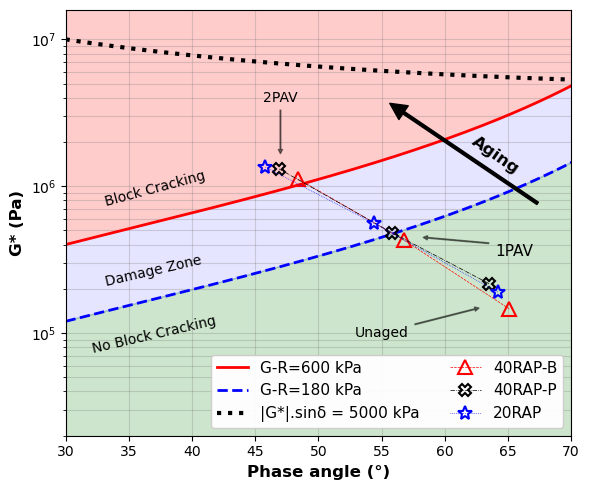

In [8]:
# Plotting the G-R in black space diagram.
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
Phase = np.linspace(30, 90, num=1000)
GR_600 = 600 * np.sin(np.deg2rad(Phase)) / (np.cos(np.deg2rad(Phase)) ** 2) * 1e3
GR_180 = 180 * np.sin(np.deg2rad(Phase)) / (np.cos(np.deg2rad(Phase)) ** 2) * 1e3
Gsind  = 5000 / np.sin(np.deg2rad(Phase)) * 1e3
# First put the common elements. 
ax.semilogy(Phase, GR_600, color='r', ls='-',  lw=2, label='G-R=600 kPa')
ax.semilogy(Phase, GR_180, color='b', ls='--', lw=2, label='G-R=180 kPa')
ax.semilogy(Phase, Gsind,  color='k', ls=':', lw=3, label='|G*|.sinδ = 5000 kPa')
ax.set_ylim([10 ** 4.3, 10 ** 7.2])
ax.set_xlim([30, 70])
ax.grid(which='both', color='gray', alpha=0.3)
ax.set_xlabel('Phase angle (°)', fontsize=12, fontweight='bold', color='k')
ax.set_ylabel('G* (Pa)', fontsize=12, fontweight='bold', color='k')
ax.text(33, 2e5, 'Damage Zone',    ha='left', va='bottom', rotation=13, fontsize=10, color='k')
ax.text(33, 7e5, 'Block Cracking', ha='left', va='bottom', rotation=15, fontsize=10, color='k')
ax.text(32, 7e4, 'No Block Cracking', ha='left', va='bottom', rotation=13, fontsize=10, color='k')
ax.annotate("",  xy=(55, 4e6), xytext=(68, 7e5), 
                arrowprops=dict(facecolor="black", shrink=0.05, width=2), 
                fontsize=12, rotation=-45, ha="center", va="center")
ax.text(64, 1.15e6, 'Aging', ha='center', va='bottom', rotation=-35, fontsize=12, color='k', fontweight='bold')

# Binder1 = ['UT64-34', 'UTBHT0.1', 'UTBHT1', 'NC64-22', 'NCBHT0.1', 'NCBHT1']
# Binder2 = ['UT64-34', 'UTZ2', 'UTZ4', 'NC64-22', 'NCZ2', 'NCZ4']
# Binder3 = ['UT64-34', 'UTEDTA0.1', 'UTEDTA2', 'NC64-22', 'NCEDTA0.1', 'NCEDTA2']
MK = ['^', 'X', '*']
MS = [10, 9, 10]
LS = ['--', '-.', ':']
CL = ['r', 'k', 'b', 'r', 'k', 'b']
# Now plot for the BHT. 
ax.semilogy(GRdata.loc[[0, 1, 2], f'Phase'], GRdata.loc[[0, 1, 2], f'Gstar'], 
            marker=MK[0], ms=MS[0], ls=LS[0], lw=0.5, color=CL[0], markerfacecolor='none', markeredgewidth=1.5, 
            label='40RAP-B')
ax.semilogy(GRdata.loc[[3, 4, 5], f'Phase'], GRdata.loc[[3, 4, 5], f'Gstar'], 
            marker=MK[1], ms=MS[1], ls=LS[1], lw=0.5, color=CL[1], markerfacecolor='none', markeredgewidth=1.5, 
            label='40RAP-P')
ax.semilogy(GRdata.loc[[6, 7, 8], f'Phase'], GRdata.loc[[6, 7, 8], f'Gstar'], 
            marker=MK[2], ms=MS[2], ls=LS[2], lw=0.5, color=CL[2], markerfacecolor='none', markeredgewidth=1.5, 
            label='20RAP')
# Fix the legends.
ax.legend(ncol=2, loc='lower right', fontsize=11, framealpha=0.95)
ax.fill_between(Phase, GR_180, np.zeros(Phase.shape), color='green', alpha=0.2)
ax.fill_between(Phase, GR_600, np.ones(Phase.shape) * 1e9, color='red', alpha=0.2)
ax.fill_between(Phase, GR_180, GR_600, color='blue', alpha=0.1)
# Add some annotates. 
ax.annotate("Unaged", xy=(63, 1.5e5), xytext=(55, 1e5), 
               arrowprops=dict(facecolor="black", shrink=0.05, width=0.5, headwidth=3, headlength=3, alpha=0.5), 
               fontsize=10, rotation=0, ha="center", va="center")
ax.annotate("1PAV", xy=(58, 4.5e5), xytext=(64, 3.6e5), 
               arrowprops=dict(facecolor="black", shrink=0.05, width=0.5, headwidth=3, headlength=3, alpha=0.5), 
               fontsize=11, rotation=0, ha="left", va="center")
ax.annotate("2PAV", xy=(47, 1.6e6), xytext=(47, 4e6), 
               arrowprops=dict(facecolor="black", shrink=0.05, width=0.5, headwidth=3, headlength=3, alpha=0.5), 
               fontsize=10, rotation=0, ha="center", va="center")
fig.tight_layout()
# fig.savefig('../_Figures/Figure05_GR_BlackSpace.png', format='png', dpi=1000)
# fig.savefig('../_Figures/Figure05_GR_BlackSpace.pdf', format='pdf')
# fig.savefig('../_Figures/Figure05_GR_BlackSpace.svg', format='svg')

_______

## Plot 06: CTOD parameter from the DENT test (failure-related property). 

Perform the analysis and plot the CTOD parameter from the failure-related DENT test for different recovered binders. 

Reading the DENT output parameters from the `Data.xlsx` file, including ligament length and cross-section area, fracture energy, and maximum load under 5 mm ligament length. 

In [ ]:
# Reading the DENT outputs. 
DENT = pd.read_excel(MainDataFile, sheet_name='DENT', skiprows=2, usecols='A:D,G,H,K,L,O,P,S,T,W,X', 
                     names=['Ligament', 'Area', 'FracEng_L7_1PAV', 'MaxLoad_L7_1PAV', 'FracEng_L7_2PAV', 'MaxLoad_L7_2PAV', 
                            'FracEng_L8_1PAV', 'MaxLoad_L8_1PAV', 'FracEng_L8_2PAV', 'MaxLoad_L8_2PAV', 
                            'FracEng_L9_1PAV', 'MaxLoad_L9_1PAV', 'FracEng_L9_2PAV', 'MaxLoad_L9_2PAV'])

,Ligament,Area,FracEng_L7_1PAV,MaxLoad_L7_1PAV,FracEng_L7_2PAV,MaxLoad_L7_2PAV,FracEng_L8_1PAV,MaxLoad_L8_1PAV,FracEng_L8_2PAV,MaxLoad_L8_2PAV,FracEng_L9_1PAV,MaxLoad_L9_1PAV,FracEng_L9_2PAV,MaxLoad_L9_2PAV
0,0.005,0.00005,0.6571,45.9,1.0419,103.6,0.8214,59.3,0.9999,109.8,0.7649,61.5,0.8906,114.8
1,0.010,0.00010,1.4050,-,2.4317,-,1.7667,-,2.2080,-,1.6821,-,2.1338,-
2,0.015,0.00015,2.4759,-,4.0829,-,2.8641,-,4.0782,-,2.9202,-,3.8040,-
3,0.005,0.00005,0.7070,48.2,0.9898,102,0.7202,54.2,0.9781,109.7,0.8416,67.3,0.8999,103.6
4,0.010,0.00010,1.5662,-,2.2600,-,1.6076,-,2.2095,-,1.7441,-,2.1944,-
5,0.015,0.00015,2.8152,-,3.8296,-,3.0493,-,4.0487,-,3.0285,-,3.8335,-


Perform the statistical analysis to calculate the CTOD parameter. Given 2 replicates at each ligament length, and three ligament lengths in total, the statistical analysis is based on 8 (2 ^ 3) different combinations. 

In [15]:
CTOD_mean, CTOD_std = [], []
for age in [1, 2]:      # Iterate over PAV aging cycles. 
    for ln in [7, 8, 9]:    # Iterate over different lanes (ln 7: 40RAP-B, ln 8: 40RAP-P, ln 9: 20RAP)    
        # Extract the results. 
        FailureEnergy = DENT[f'FracEng_L{ln}_{age}PAV'].to_numpy().astype(float)    # Failure energy from test (J). 
        MaxForce      = DENT.loc[[0, 3], f'MaxLoad_L{ln}_{age}PAV'].to_numpy().astype(float)
        Area          = DENT['Area'].to_numpy().astype(float)                       # Ligament area in m2.
        Ligament      = DENT['Ligament'].to_numpy().astype(float)                   # Ligament length in m.
        Wt            = FailureEnergy / Area                                        # Wt (J/m2)
        # Perform the fitting: Generate all combinations and fit for each. 
        combinations = list(itertools.product([0, 3], [1, 4], [2, 5]))
        CTOD = []
        for j, comb in enumerate(combinations):
            comb = np.array(comb)
            coef = np.polyfit(Ligament[comb], Wt[comb], 1)
            Intercept = coef[1]
            CTOD.append((Intercept / (MaxForce / Area[0])).mean() * 1000)        # CTOD in mm. 
        CTOD = np.array(CTOD)
        CTOD_mean.append(CTOD.mean())
        CTOD_std.append(CTOD.std())
        print(f'For Lane {ln} and {age}PAV-aged, CTOD: {CTOD.mean():.2f}, +-{CTOD.std():.4f}')

For Lane 7 and 1PAV-aged, CTOD: 12.10, +-1.1068
For Lane 8 and 1PAV-aged, CTOD: 11.51, +-1.2672
For Lane 9 and 1PAV-aged, CTOD: 10.82, +-0.8213
For Lane 7 and 2PAV-aged, CTOD: 8.43, +-0.4566
For Lane 8 and 2PAV-aged, CTOD: 7.14, +-0.1358
For Lane 9 and 2PAV-aged, CTOD: 6.48, +-0.0793


Plot the results in terms of bar plot. 

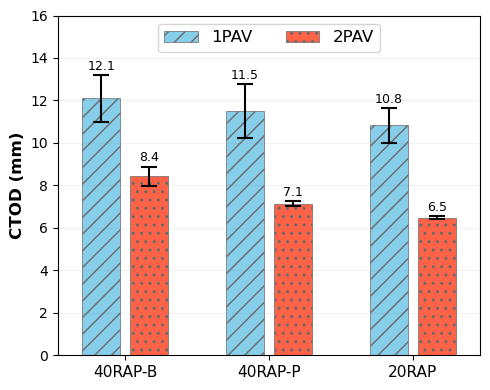

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.bar([1, 4, 7], height=CTOD_mean[:3], yerr=CTOD_std[:3], width=0.8, 
          edgecolor='dimgray', lw=0.5, color='skyblue', hatch='//', label='1PAV',
          error_kw={'capsize': 6, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
ax.bar([2, 5, 8], height=CTOD_mean[3:], yerr=CTOD_std[3:], width=0.8, 
          edgecolor='dimgray', lw=0.5, color='tomato', hatch='..', label='2PAV',
          error_kw={'capsize': 6, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
ax.set_ylim([0, 16])
ax.set_xticks([1.5, 4.5, 7.5])
ax.set_xticklabels(['40RAP-B', '40RAP-P', '20RAP'], fontsize=11, color='k', rotation=0)
ax.set_ylabel('CTOD (mm)', fontsize=12, fontweight='bold', color='k')
for i in range(3):
    ax.text([1, 4, 7][i], CTOD_mean[i] + CTOD_std[i] + 0.1, f'{CTOD_mean[i]:.1f}', 
            ha='center', va='bottom', fontsize=9)
    ax.text([2, 5, 8][i], CTOD_mean[i+3] + CTOD_std[i+3] + 0.1, f'{CTOD_mean[i+3]:.1f}', 
            ha='center', va='bottom', fontsize=9)
ax.set_xlim([0.1, 8.9])
ax.grid(axis='y', color='gray', alpha=0.1)
ax.legend(fontsize=12, ncol=2, loc='upper center')
fig.tight_layout()
# fig.savefig('../_Figures/Figure06_DENT_Results.png', format='png', dpi=1000)
# fig.savefig('../_Figures/Figure06_DENT_Results.pdf', format='pdf')
# fig.savefig('../_Figures/Figure06_DENT_Results.svg', format='svg')

_______

## Plot 07: LTPG loss parameter from the extended BBR test. 

Analysis and plot the calculated LTPG loss parameter for different recovered binders.

First, reading the S-values and m-values from the `Data.xlsx` file for the recovered binder from each lane and under different laboratory long-term aging (1PAV and 2PAV). 

In [17]:
# Read the data. 
ExtBBR_Ln7_1PAV = pd.read_excel(MainDataFile, sheet_name='Extended BBR', usecols='B:J', skiprows=4,
                                names=['CondTime', 'CondTemp', 'TestTemp', 'Sval1', 'Sval2', 'Sval3', 'mval1', 'mval2', 'mval3'])
ExtBBR_Ln7_2PAV = pd.read_excel(MainDataFile, sheet_name='Extended BBR', usecols='K:S', skiprows=4,
                                names=['CondTime', 'CondTemp', 'TestTemp', 'Sval1', 'Sval2', 'Sval3', 'mval1', 'mval2', 'mval3'])
ExtBBR_Ln8_1PAV = pd.read_excel(MainDataFile, sheet_name='Extended BBR', usecols='T:AB', skiprows=4,
                                names=['CondTime', 'CondTemp', 'TestTemp', 'Sval1', 'Sval2', 'Sval3', 'mval1', 'mval2', 'mval3'])
ExtBBR_Ln8_2PAV = pd.read_excel(MainDataFile, sheet_name='Extended BBR', usecols='AC:AK', skiprows=4,
                                names=['CondTime', 'CondTemp', 'TestTemp', 'Sval1', 'Sval2', 'Sval3', 'mval1', 'mval2', 'mval3'])
ExtBBR_Ln9_1PAV = pd.read_excel(MainDataFile, sheet_name='Extended BBR', usecols='AL:AT', skiprows=4,
                                names=['CondTime', 'CondTemp', 'TestTemp', 'Sval1', 'Sval2', 'Sval3', 'mval1', 'mval2', 'mval3'])
ExtBBR_Ln9_2PAV = pd.read_excel(MainDataFile, sheet_name='Extended BBR', usecols='AU:BC', skiprows=4,
                                names=['CondTime', 'CondTemp', 'TestTemp', 'Sval1', 'Sval2', 'Sval3', 'mval1', 'mval2', 'mval3'])

Next, defining a function to calculate the LTPG and ΔTc from the calculated S-values and m-values at different temperatures. 

In [18]:
def Calc_LTPG_DeltaTC(t1, t2, Svals_t1, Svals_t2, mvals_t1, mvals_t2):
    """
    Calculate the LTPG and DeltaTC from the BBR test results. 

    :param t1: First testing temperature (°C).
    :param t2: Second testing temperature (°C).
    :param Svals_t1: An array of stiffness values at 60 s at first testing temperature (MPa). 
    :param Svals_t2: An array of stiffness values at 60 s at second testing temperature (MPa). 
    :param mvals_t1: An array of relaxation values at 60 s at first testing temperature. 
    :param mvals_t2: An array of relaxation values at 60 s at second testing temperature. 
    """
    Res = {}
    # Calculate the Ts. 
    Combinations = list(itertools.product(range(len(Svals_t1)), range(len(Svals_t2))))
    Ts = np.zeros(len(Combinations))
    for i, comb in enumerate(Combinations):
        Slope     = (Svals_t2[comb[1]] - Svals_t1[comb[0]]) / (t2 - t1)
        Intercept = Svals_t1[comb[0]] - Slope * t1
        Ts[i] = (300 - Intercept) / Slope
    # Calculate the Tm. 
    Combinations = list(itertools.product(range(len(mvals_t1)), range(len(mvals_t2))))
    Tm = np.zeros(len(Combinations))
    for i, comb in enumerate(Combinations):
        Slope     = (mvals_t2[comb[1]] - mvals_t1[comb[0]]) / (t2 - t1)
        Intercept = mvals_t1[comb[0]] - Slope * t1
        Tm[i] = (0.3 - Intercept) / Slope
    # Store the Ts and Tm. 
    Res['Tm'] = Tm
    Res['Ts'] = Ts
    # Calculate the Delta_Tc. 
    Res['DeltaTc_mean'] = Ts.mean() - Tm.mean()
    Res['DeltaTc_std']  = np.sqrt(Ts.std() ** 2 + Tm.std() ** 2)
    # Calculate the LTPG. 
    if Tm.mean() < Ts.mean():
        Res['LTPG_mean'] = Ts.mean() - 10
        Res['LTPG_std']  = Ts.std()
        Res['LTPG']      = Ts - 10
    else:
        Res['LTPG_mean'] = Tm.mean() - 10
        Res['LTPG_std']  = Tm.std()
        Res['LTPG']      = Tm - 10
    # Return the result. 
    return Res

Next, defining a function to calculate the LTPG loss parameter from the BBR test results under different conditioning environments. It is noted that according to the extended BBR procedure, the test will be performed under LTPG + 10°C and LTPG + 20°C. Therefore, the LTPG of the binder is calculated using 1 hour of conditioning at LTPG + 10°C.

In [19]:
def Calc_LTPGLoss_ExtBBR(data):
    """
    This function calculates the LTPG loss from the Extended BBR tests. 

    :param data: A Dataframe of the Extended BBR test results at different conditioning times and temperatures. 
    :return: The loss of LTPG (mean and std). 
    """
    ExtBBR = {'CondTime': [], 'CondTemp': [], 'LTPG_mean': [], 'LTPG_std': []}
    # Get the LTPG temperature. 
    LTPG_Temp = data['CondTemp'].min()
    # Iterate over different tests. 
    for ctime in data['CondTime'].unique():
        df1 = data[data['CondTime'] == ctime]
        for ctemp in df1['CondTemp'].unique():
            df2 = df1[df1['CondTemp'] == ctemp].reset_index()
            # Extract the data.
            t1, t2 = df2['TestTemp'].tolist()
            Svals_t1 = checkArr([df2.loc[0, f'Sval{i}'] for i in [1, 2, 3] if not np.isnan(df2.loc[0, f'Sval{i}'])])
            Svals_t2 = checkArr([df2.loc[1, f'Sval{i}'] for i in [1, 2, 3] if not np.isnan(df2.loc[1, f'Sval{i}'])])
            mvals_t1 = checkArr([df2.loc[0, f'mval{i}'] for i in [1, 2, 3] if not np.isnan(df2.loc[0, f'mval{i}'])])
            mvals_t2 = checkArr([df2.loc[1, f'mval{i}'] for i in [1, 2, 3] if not np.isnan(df2.loc[1, f'mval{i}'])])
            # Calculate the LTPG. 
            Res = Calc_LTPG_DeltaTC(t1, t2, Svals_t1, Svals_t2, mvals_t1, mvals_t2)
            # Store the results. 
            ExtBBR['CondTime'].append(ctime)
            ExtBBR['CondTemp'].append(ctemp)
            ExtBBR['LTPG_mean'].append(Res['LTPG_mean'])
            ExtBBR['LTPG_std'].append(Res['LTPG_std'])
    ExtBBR = pd.DataFrame(ExtBBR)           # Convert ExtBBR to DataFrame. 
    # Calculate the LTPG loss. 
    LTPG_PG_mean   = ExtBBR[(ExtBBR['CondTime'] == 1) & (ExtBBR['CondTemp'] == LTPG_Temp)].iloc[0]['LTPG_mean']
    LTPG_PG_std    = ExtBBR[(ExtBBR['CondTime'] == 1) & (ExtBBR['CondTemp'] == LTPG_Temp)].iloc[0]['LTPG_std']
    LTPG_Max_mean  = ExtBBR['LTPG_mean'].max()
    LTPG_Max_Std   = ExtBBR[ExtBBR['LTPG_mean'] == ExtBBR['LTPG_mean'].max()].iloc[0]['LTPG_std']
    LTPG_Loss_mean = LTPG_PG_mean - LTPG_Max_mean
    LTPG_Loss_std  = np.sqrt(LTPG_PG_std ** 2 + LTPG_Max_Std ** 2)
    # Return the LTPG loss values. 
    return LTPG_Loss_mean, LTPG_Loss_std

Perfrom the analysis and re-organize the results. 

In [20]:
# Calculate the LTPG loss for different lanes at different agings. 
LTPGLoss = {
    'Lane7': {
        '1PAV': Calc_LTPGLoss_ExtBBR(ExtBBR_Ln7_1PAV), 
        '2PAV': Calc_LTPGLoss_ExtBBR(ExtBBR_Ln7_2PAV)},
    'Lane8': {
        '1PAV': Calc_LTPGLoss_ExtBBR(ExtBBR_Ln8_1PAV), 
        '2PAV': Calc_LTPGLoss_ExtBBR(ExtBBR_Ln8_2PAV)},
    'Lane9': {
        '1PAV': Calc_LTPGLoss_ExtBBR(ExtBBR_Ln9_1PAV), 
        '2PAV': Calc_LTPGLoss_ExtBBR(ExtBBR_Ln9_2PAV)}
}
# Reorganize. 
LTPGLoss_1PAV_mean = np.array([LTPGLoss[f'Lane{i}']['1PAV'][0] for i in [7, 8, 9]])
LTPGLoss_1PAV_std  = np.array([LTPGLoss[f'Lane{i}']['1PAV'][1] for i in [7, 8, 9]])
LTPGLoss_2PAV_mean = np.array([LTPGLoss[f'Lane{i}']['2PAV'][0] for i in [7, 8, 9]])
LTPGLoss_2PAV_std  = np.array([LTPGLoss[f'Lane{i}']['2PAV'][1] for i in [7, 8, 9]])

Plot the LTPG loss parameter as bar plot. 

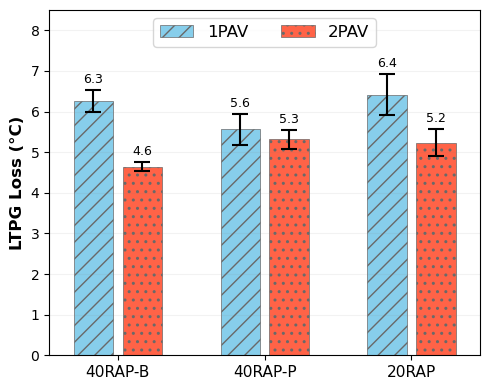

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.bar([1, 4, 7], height=LTPGLoss_1PAV_mean[:3] * -1, yerr=LTPGLoss_1PAV_std[:3], width=0.8, 
          edgecolor='dimgray', lw=0.5, color='skyblue', hatch='//', label='1PAV',
          error_kw={'capsize': 6, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
ax.bar([2, 5, 8], height=LTPGLoss_2PAV_mean[:3] * -1, yerr=LTPGLoss_2PAV_std[:3], width=0.8, 
          edgecolor='dimgray', lw=0.5, color='tomato', hatch='..', label='2PAV',
          error_kw={'capsize': 6, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
ax.set_ylim([0, 8.5])
ax.set_xticks([1.5, 4.5, 7.5])
ax.set_xticklabels(['40RAP-B', '40RAP-P', '20RAP'], fontsize=11, color='k', rotation=0)
ax.set_ylabel('LTPG Loss (°C)', fontsize=12, fontweight='bold', color='k')
for i in range(3):
    ax.text([1, 4, 7][i], -1 * LTPGLoss_1PAV_mean[i] + LTPGLoss_1PAV_std[i] + 0.1, f'{LTPGLoss_1PAV_mean[i] * -1:.1f}', 
            ha='center', va='bottom', fontsize=9)
    ax.text([2, 5, 8][i], -1 * LTPGLoss_2PAV_mean[i] + LTPGLoss_2PAV_std[i] + 0.1, f'{LTPGLoss_2PAV_mean[i] * -1:.1f}', 
            ha='center', va='bottom', fontsize=9)
ax.set_xlim([0.1, 8.9])
ax.grid(axis='y', color='gray', alpha=0.1)
ax.legend(fontsize=12, ncol=2, loc='upper center')
fig.tight_layout()
# fig.savefig('../_Figures/Figure07_LTPG_Loss_Results.png', format='png', dpi=1000)
# fig.savefig('../_Figures/Figure07_LTPG_Loss_Results.pdf', format='pdf')
# fig.savefig('../_Figures/Figure07_LTPG_Loss_Results.svg', format='svg')